In [2]:
from pathlib import Path
print("Current working directory:", Path.cwd())

Current working directory: c:\Users\User\Desktop\my-local-repo\sports_modelling\models


In [3]:
import numpy as np
import pandas as pd
from pathlib import Path

# Resolve data directory relative to the notebook location (../data)
data_dir = (Path.cwd().parent / "data").resolve()
processed_dir = data_dir / "processed"
print(processed_dir)

# Helper to choose processed file first, else fallback raw by league code
def find_project_root(start_path: Path) -> Path:
    """
    Walk upward from the current directory until a folder containing 'data' is found.
    """
    for parent in [start_path, *start_path.parents]:
        if (parent / "data").exists():
            return parent
    raise RuntimeError("Could not find project root containing a 'data' folder.")

# Load all requested leagues
leagues = ["ENG", "FRA", "SPA"]
league_dfs = {}

for code in leagues:
    path = find_project_root(Path.cwd()) / "data" / "processed" / f"{code}_combined.csv"
    df = pd.read_csv(path)
    df = df[df["Minute"] > 0]
    league_dfs[code] = df

# Unpack for convenience
premier_league_df = league_dfs["ENG"]
league1_df = league_dfs["FRA"]
laliga_df = league_dfs["SPA"]

print("Loaded leagues:", ", ".join(league_dfs.keys()))
print(f"ENG columns: {premier_league_df.columns.tolist()}")
print(f"FRA columns: {league1_df.columns.tolist()}")
print(f"SPA columns: {laliga_df.columns.tolist()}")

C:\Users\User\Desktop\my-local-repo\sports_modelling\data\processed
Loaded leagues: ENG, FRA, SPA
ENG columns: ['RBallID', 'HomeTeam', 'AwayTeam', 'Timestamp', 'Incident', 'IncidentNumber', 'Minute']
FRA columns: ['RBallID', 'HomeTeam', 'AwayTeam', 'Timestamp', 'Incident', 'IncidentNumber', 'Minute']
SPA columns: ['RBallID', 'HomeTeam', 'AwayTeam', 'Timestamp', 'Incident', 'IncidentNumber', 'Minute']


In [7]:
def assign_season(dt) :
    month = dt.month
    year = dt.year
    return f"{year}-{year+1}" if month >= 8 else f"{year-1}-{year}"

def create_basic_dataset(df: pd.DataFrame) -> pd.DataFrame:
    """
    Create a basic dataset with selected features for modeling.
    """
    stats = {
        "Home Goals": (df["Incident"] == "GOAL1"),
        "Away Goals": (df["Incident"] == "GOAL2"),
        "Home Corners": (df["Incident"] == "CR1"),
        "Away Corners": (df["Incident"] == "CR2"),
        "Home Shots on Target": (df['Incident'] == 'SHG1'),
        "Away Shots on Target": (df['Incident'] == 'SHG2'),
        "Home Fouls": (df['Incident'] == 'F1'),
        "Away Fouls": (df['Incident'] == 'F2'),
        "Home Offsides": (df['Incident'] == 'O1'),
        "Away Offsides": (df['Incident'] == 'O2'),
        "Home Penalties": (df['Incident'] == 'PEN1'),
        "Away Penalties": (df['Incident'] == 'PEN2'),
        "Home Shots Blocked": (df['Incident'] == 'BLOCKED1'),
        "Away Shots Blocked": (df['Incident'] == 'BLOCKED2'),
        "Home Goal Kicks": (df['Incident'] == 'GK1'),
        "Away Goal Kicks": (df['Incident'] == 'GK2'),
        "Home Shots off Target": (df['Incident'] == 'SHB1'),
        "Away Shots off Target": (df['Incident'] == 'SHB2'),
        "Home Throwins": (df['Incident'] == 'TI1'),
        "Away Throwins": (df['Incident'] == 'TI2'),
        "Home Shots Woodwork": (df['Incident'] == 'SHW1'),
        "Away Shots Woodwork": (df['Incident'] == 'SHW2'),
    }
    df["Season"] = pd.to_datetime(df["Timestamp"]).apply(assign_season)

    for name, mask in stats.items():
        df[name] = mask.astype(int)

    agg_cols = list(stats.keys())
    aggregated = df.groupby(["RBallID", "HomeTeam", "AwayTeam", "Season"])[agg_cols].sum().reset_index()
    aggregated["Result"] = np.where(
        aggregated["Home Goals"] > aggregated["Away Goals"], "H",
        np.where(
            aggregated["Home Goals"] < aggregated["Away Goals"],"A", "D"
        )
    )
    return aggregated

premier_basic_df = create_basic_dataset(premier_league_df)
league1_basic_df = create_basic_dataset(league1_df)
laliga_basic_df = create_basic_dataset(laliga_df) 


In [8]:
premier_basic_df.head()

,RBallID,HomeTeam,AwayTeam,Season,Home Goals,Away Goals,Home Corners,Away Corners,Home Shots on Target,Away Shots on Target,...,Away Shots Blocked,Home Goal Kicks,Away Goal Kicks,Home Shots off Target,Away Shots off Target,Home Throwins,Away Throwins,Home Shots Woodwork,Away Shots Woodwork,Result
0,849137,Arsenal FC,Leicester City FC,2017-2018,4,3,9,4,6,1,...,0,6,12,10,2,21,32,0,0,H
1,849138,Watford FC,Liverpool FC,2017-2018,3,3,3,3,2,2,...,1,12,7,2,7,27,27,0,1,D
2,849139,Chelsea FC,Burnley FC,2017-2018,3,4,8,5,10,2,...,1,4,10,7,3,12,8,0,1,A
3,849140,Crystal Palace FC,Huddersfield Town FC,2017-2018,0,3,12,9,3,4,...,0,3,10,7,2,19,29,0,0,A
4,849141,Everton FC,Stoke City FC,2017-2018,1,0,6,7,3,2,...,2,10,8,3,4,25,28,0,0,H


In [13]:
def update_elo(home_elo, away_elo, result, k = 30, home_advantage = 80):
    expected_home = 1/(1 +10 ** ((away_elo - (home_elo + home_advantage))/400))
    expected_away = 1 - expected_home
    if result == 'H':
        score_home, score_away = 1, 0
    elif result == 'A':
        score_home, score_away = 0, 1
    else:
        score_home, score_away = 0.5, 0.5
    new_home_elo = home_elo + k * (score_home - expected_home)
    new_away_elo = away_elo + k * (score_away - expected_away)
    return new_home_elo, new_away_elo

In [21]:
# ---------------------------------------------
# Initialize parameters
# ---------------------------------------------
initial_elo = 1500
k = 30
home_advantage = 80
regression_factor = 0.2
promoted_adjustment = 0.85


# Columns to store ELOs
home_elos_list = []
away_elos_list = []

team_elos = {}

# Process each season separately
for season, season_df in premier_basic_df.groupby("Season", sort=True):

    if len(team_elos) > 0:
        league_mean = sum(team_elos.values()) / len(team_elos)

        for t in team_elos:
            team_elos[t] = league_mean + (1-regression_factor) * (team_elos[t] - league_mean)


    # Iterate over matches in order
    for idx, row in season_df.iterrows():
        home = row["HomeTeam"]
        away = row["AwayTeam"]
        result = row["Result"]

        # handle new teams entering the league
        if home not in team_elos:
            current_mean = sum(team_elos.values()) / len(team_elos) if team_elos else 1500
            team_elos[home] = 1500 - promoted_adjustment * (current_mean - 1500)

        if away not in team_elos:
            current_mean = sum(team_elos.values()) / len(team_elos) if team_elos else 1500
            team_elos[away] = 1500 - promoted_adjustment * (current_mean - 1500)

        home_elo = team_elos[home]
        away_elo = team_elos[away]

        # Append current ELOs
        home_elos_list.append(home_elo)
        away_elos_list.append(away_elo)

        # Update ELOs
        new_home_elo, new_away_elo = update_elo(home_elo, away_elo, result,
                                                k=k, home_advantage=home_advantage)
        team_elos[home] = new_home_elo
        team_elos[away] = new_away_elo

# Assign back to dataframe
premier_basic_df['HomeElo'] = home_elos_list
premier_basic_df['AwayElo'] = away_elos_list

premier_basic_df[premier_basic_df['Season'] == "2018-2019"].head(50)

,RBallID,HomeTeam,AwayTeam,Season,Home Goals,Away Goals,Home Corners,Away Corners,Home Shots on Target,Away Shots on Target,...,Away Goal Kicks,Home Shots off Target,Away Shots off Target,Home Throwins,Away Throwins,Home Shots Woodwork,Away Shots Woodwork,Result,HomeElo,AwayElo
373,1004630,Manchester United FC,Leicester City FC,2018-2019,2,1,2,5,4,3,...,4,1,3,22,19,0,0,H,1639.408979,1479.462221
374,1004631,Newcastle United FC,Tottenham Hotspur FC,2018-2019,1,2,3,5,3,6,...,10,6,7,37,24,2,1,A,1481.531385,1611.237175
375,1004632,AFC Bournemouth,Cardiff City FC,2018-2019,2,0,7,4,1,2,...,10,5,3,31,20,0,0,H,1482.030656,1500.000000
376,1004633,Fulham FC,Crystal Palace FC,2018-2019,0,3,5,5,7,9,...,8,2,0,16,25,0,0,A,1500.000000,1497.070972
377,1004634,Huddersfield Town FC,Chelsea FC,2018-2019,0,3,2,5,2,1,...,6,3,3,23,30,1,1,A,1419.150470,1557.207348
378,1004635,Watford FC,Brighton & Hove Albion FC,2018-2019,2,0,8,2,3,1,...,10,6,5,16,19,0,0,H,1427.776600,1442.789633
379,1004636,Wolverhampton Wanderers FC,Everton FC,2018-2019,2,2,3,6,2,3,...,10,7,1,32,19,0,0,D,1500.000000,1478.022877
380,1004637,Liverpool FC,West Ham United FC,2018-2019,4,0,5,4,5,2,...,11,4,3,12,20,0,0,H,1627.041576,1488.762535
381,1004638,Southampton FC,Burnley FC,2018-2019,0,0,8,5,7,7,...,12,6,4,23,15,0,0,D,1458.007565,1503.861401
382,1004639,Arsenal FC,Manchester City FC,2018-2019,0,2,2,10,3,6,...,8,4,5,16,21,0,0,A,1504.926891,1683.541323


## Checking the behavior of the team elo function

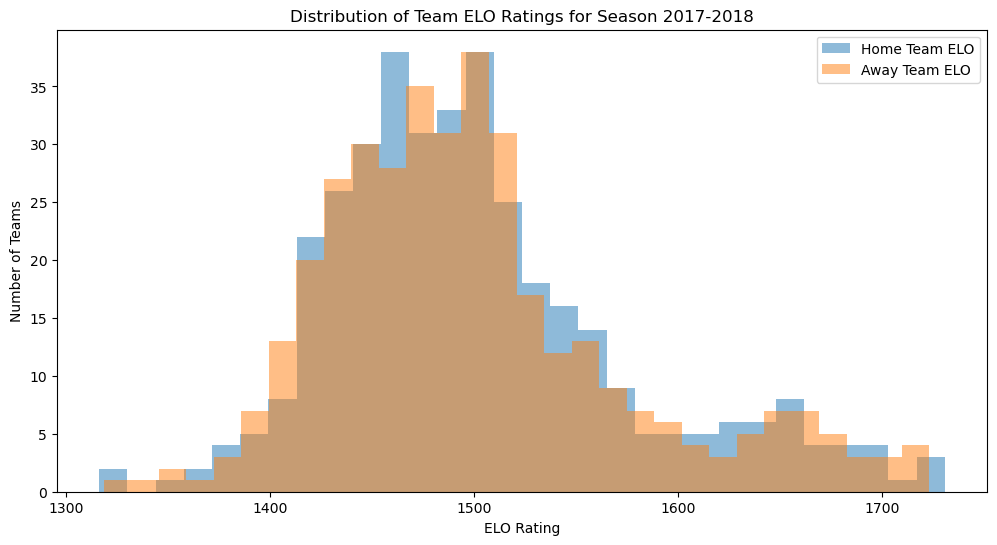

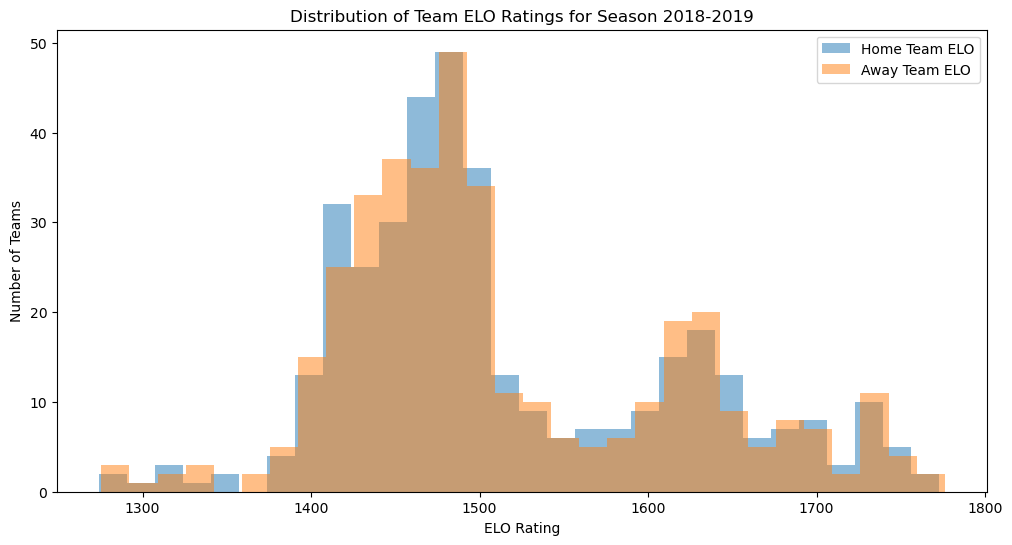

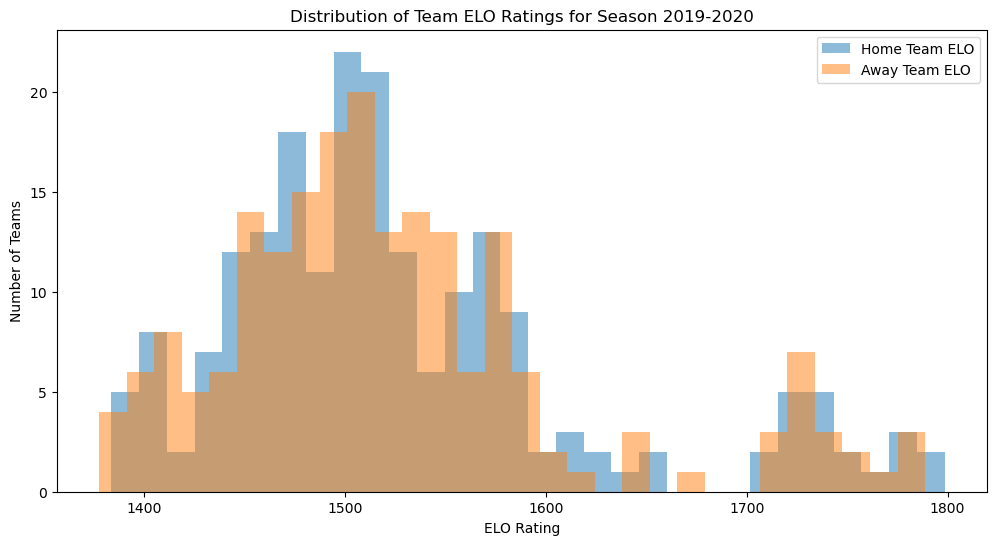

In [26]:
# plot the histograms of away team elo and home team elo for season 2018-2019
import matplotlib.pyplot as plt
seasons = premier_basic_df['Season'].unique()
for season in seasons :
    season_dataframe = premier_basic_df[premier_basic_df['Season'] == season]
    plt.figure(figsize=(12, 6))
    plt.hist(season_dataframe['HomeElo'], bins=30, alpha=0.5, label='Home Team ELO')
    plt.hist(season_dataframe['AwayElo'], bins=30, alpha=0.5, label='Away Team ELO')
    plt.title(f'Distribution of Team ELO Ratings for Season {season}')
    plt.xlabel('ELO Rating')
    plt.ylabel('Number of Teams')
    plt.legend()
    plt.show()



## define win probabilities for each match

In [35]:
def elo_probabilities(home_elo, away_elo, home_advantage = 80):
    ExpH = 1 / (1+10 **((away_elo - (home_elo + home_advantage))/400))

    d = home_elo - away_elo 
    P_draw = 0.28 * np.exp(-abs(d)/ 400)
    P_home = ExpH - P_draw / 2
    P_away = 1 - P_home - P_draw
    return P_home, P_draw,  P_away

probs = premier_basic_df.apply(
    lambda r: elo_probabilities(r['HomeElo'], r['AwayElo']),
    axis = 1,
    result_type='expand'
)
premier_basic_df["P_Home"] = probs[0]
premier_basic_df["P_Draw"] = probs[1]
premier_basic_df["P_Away"] = probs[2]
premier_basic_df["Odds_Home"] = 1 / premier_basic_df["P_Home"]
premier_basic_df["Odds_Draw"] = 1 / premier_basic_df["P_Draw"]
premier_basic_df["Odds_Away"] = 1 / premier_basic_df["P_Away"]
premier_basic_df.head(400)

,RBallID,HomeTeam,AwayTeam,Season,Home Goals,Away Goals,Home Corners,Away Corners,Home Shots on Target,Away Shots on Target,...,Away Shots Woodwork,Result,HomeElo,AwayElo,P_Home,P_Draw,P_Away,Odds_Home,Odds_Draw,Odds_Away
0,849137,Arsenal FC,Leicester City FC,2017-2018,4,3,9,4,6,1,...,0,H,1500.000000,1500.000000,0.473137,0.280000,0.246863,2.113554,3.571429,4.050827
1,849138,Watford FC,Liverpool FC,2017-2018,3,3,3,3,2,2,...,1,D,1500.000000,1500.000000,0.473137,0.280000,0.246863,2.113554,3.571429,4.050827
2,849139,Chelsea FC,Burnley FC,2017-2018,3,4,8,5,10,2,...,1,A,1500.000000,1500.000000,0.473137,0.280000,0.246863,2.113554,3.571429,4.050827
3,849140,Crystal Palace FC,Huddersfield Town FC,2017-2018,0,3,12,9,3,4,...,0,A,1500.000000,1500.000000,0.473137,0.280000,0.246863,2.113554,3.571429,4.050827
4,849141,Everton FC,Stoke City FC,2017-2018,1,0,6,7,3,2,...,0,H,1500.000000,1500.000000,0.473137,0.280000,0.246863,2.113554,3.571429,4.050827
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
395,1008910,Arsenal FC,West Ham United FC,2018-2019,3,1,7,2,9,4,...,0,H,1485.377427,1464.227460,0.508799,0.265580,0.225622,1.965413,3.765349,4.432201
396,1008911,Fulham FC,Burnley FC,2018-2019,4,2,6,4,7,0,...,0,H,1474.967302,1484.398589,0.463445,0.273475,0.263080,2.157753,3.656637,3.801129
397,1008912,Huddersfield Town FC,Cardiff City FC,2018-2019,1,0,7,7,1,7,...,0,H,1403.410253,1483.488361,0.385288,0.229200,0.385512,2.595463,4.363005,2.593950
398,1008913,Southampton FC,Leicester City FC,2018-2019,1,2,10,3,4,3,...,0,A,1445.968327,1485.968714,0.430634,0.253354,0.316012,2.322158,3.947043,3.164439


In [ ]:
## perform a sanity check that the probabilities sume to 1
(premier_basic_df["P_Home"] + premier_basic_df["P_Draw"] + premier_basic_df["P_Away"]).describe()

count    9.520000e+02
mean     1.000000e+00
std      2.741789e-17
min      1.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      1.000000e+00
max      1.000000e+00
dtype: float64